In [1]:
!git clone https://github.com/AvonYangXX1/AMPLify-Feedback.git
!pip install Levenshtein
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import numpy as np
import math
import matplotlib.pyplot as plt
import statistics
from Levenshtein import distance as lev
import pandas as pd

Cloning into 'AMPLify-Feedback'...
remote: Enumerating objects: 494, done.
remote: Counting objects: 100% (143/143), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 494 (delta 72), reused 131 (delta 67), pack-reused 351
Receiving objects: 100% (494/494), 246.83 MiB | 12.12 MiB/s, done.
Resolving deltas: 100% (239/239), done.
Updating files: 100% (96/96), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 19.3 MB/s eta 0:00:00


In [2]:
generator = tf.keras.models.load_model('AMPLify-Feedback/model_weights/PeptideGenerator_new.keras')

In [3]:
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input0 (InputLayer)         [(None, 2)]               0         
                                                                 
 Dense0 (Dense)              (None, 256)               768       
                                                                 
 Norm0 (BatchNormalization)  (None, 256)               1024      
                                                                 
 Dense1 (Dense)              (None, 256)               65792     
                                                                 
 Norm1 (BatchNormalization)  (None, 256)               1024      
                                                                 
 Dense2 (Dense)              (None, 256)               65792     
                                                                 
 Norm2 (BatchNormalization)  (None, 256)               1024  

In [4]:
def create_oracle():
    inputs0 = tf.keras.layers.Input((190,43),name="SeqInput")
    inputs1 = tf.keras.layers.Input((326,),name="StateInput")
    x = tf.keras.layers.Conv1D(128, 5, activation='relu', name="Conv1D_0")(inputs0) # kernel_size=5 works well
    x = tf.keras.layers.Conv1D(128, 5, activation='relu', name="Conv1D_1")(x) # Just two layers work better
    x = tf.keras.layers.Flatten(name="Flatten_0")(x)
    x = tf.keras.layers.Dense(512, activation="relu", name="LearnSeqDense_0")(x)
    x = tf.keras.layers.Concatenate(axis=1, name="Concat")([x, inputs1])
    x = tf.keras.layers.Dense(1024, activation="relu", name="LearnConcatDense_0")(x)
    x = tf.keras.layers.LayerNormalization(name="LayerNorm_0")(x)
    x = tf.keras.layers.Dense(512, activation="relu", name="LearnConcatDense_1")(x)
    x = tf.keras.layers.LayerNormalization(name="LayerNorm_1")(x)
    x = tf.keras.layers.Dense(1, activation="linear", name="Output")(x)
    model = tf.keras.models.Model([inputs0, inputs1], x, name="MICPredictor")
    return model

In [5]:
oracle = create_oracle()
path = "AMPLify-Feedback/model_weights/MICPredictor"
for i, layer in enumerate(oracle.layers):
    weights = np.load(f"{path}/layer_{i}_weights.npy", allow_pickle=True)
    layer.set_weights(weights)

In [6]:
oracle.summary()

Model: "MICPredictor"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 SeqInput (InputLayer)       [(None, 190, 43)]            0         []                            
                                                                                                  
 Conv1D_0 (Conv1D)           (None, 186, 128)             27648     ['SeqInput[0][0]']            
                                                                                                  
 Conv1D_1 (Conv1D)           (None, 182, 128)             82048     ['Conv1D_0[0][0]']            
                                                                                                  
 Flatten_0 (Flatten)         (None, 23296)                0         ['Conv1D_1[0][0]']            
                                                                                       

In [7]:
aa_vocal = np.load("AMPLify-Feedback/model_weights/SeqTV_vocal.npy")
pep_decoder = tf.keras.layers.StringLookup(vocabulary=aa_vocal[1:], invert=True, oov_token='')
species_vocal = np.load("AMPLify-Feedback/model_weights/SpeciesTV_vocal.npy")
species_decoder = tf.keras.layers.StringLookup(vocabulary=species_vocal[1:], invert=True, oov_token='')

In [9]:
def generate_sequences(generator, latent_dim, num_sequences):
    noise = (np.random.rand(num_sequences, latent_dim)-0.5)*2
    generated_sequences = generator.predict(noise, verbose=0)
    return onehot2seq(generated_sequences)

In [10]:
def onehot2seq(onehot):
  decoded_sequences = []
  for s in onehot:
    chars_array = pep_decoder(tf.math.argmax([s], axis=2)).numpy().astype('str')
    decoded_sequences += ["".join(chars) for chars in chars_array]
  return decoded_sequences

In [11]:
def coordinates_grid(num_bins) :
  labels = np.round(np.linspace(-1, 1, num_bins), 2)
  noise = []
  for x in labels:
    for y in labels:
        noise.append([x, y])
  noise = np.array(noise)
  num_sequences = len(noise)
  return noise, num_sequences, labels

In [12]:
def hallucination_mapping(num_bins, target):
  #Search coordinates in the noise plane
  noise, num_sequences, labels = coordinates_grid(num_bins)
  # Look up the index of the target bacteria
  bacteria = np.zeros(shape=(num_sequences, 326))
  index = np.where(species_vocal==target)[0][0]
  bacteria[:, index] = 1
  return noise, num_sequences, bacteria

In [13]:
def selected_data(hallucination_data, n_max, MIC_threshold) :
  #Order by increasing MIC and select the top n_max sequences
  hallucination_data['MIC'].sort_values(ascending=True).head(n_max)
  #Exclude if above MIC_theshold
  hallucination_data = hallucination_data[hallucination_data.MIC.astype(np.float64) < MIC_threshold]
  return hallucination_data

In [14]:
@tf.function
def compute_gradient(noise, oracle, bacteria, generator_optimizer):
    noise = tf.convert_to_tensor(noise, np.float64)
    with tf.GradientTape() as gen_tape:
        gen_tape.watch(noise)
        generated_onehot = generator(noise, training=True)
        generator_loss = tf.reduce_mean(oracle([generated_onehot, bacteria]))
    gradients_of_generator = gen_tape.gradient(generator_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    return generated_onehot

In [15]:
def RL_loop(generator, oracle, aa_vocal, pep_decoder, n_bins, target):
  average_mic_train, min_mic_train, max_mic_train, median_mic_train, levenstein  = [], [], [], [], []
  generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  for i in range (n_iter_max) :
    #Sequences prediction and gradient computation
    noise, num_sequences, bacteria = hallucination_mapping(n_bins, target)
    generated_onehot = compute_gradient(noise, oracle, bacteria, generator_optimizer)
    generated_sequences = onehot2seq(generated_onehot)

    #Oracle results and statistics
    MIC = oracle([generated_onehot, bacteria])
    average_mic_train += [np.mean(MIC)]
    min_mic_train += [np.min(MIC)]
    max_mic_train += [np.max(MIC)]
    median_mic_train += [np.median(MIC)]
    levenstein += [variability_metrics(generated_sequences, aa_vocal, pep_decoder)]

    print(f"Iter {i+1}/{n_iter_max}; Average MIC {np.mean(MIC):.4f}; Levenshtein {variability_metrics(generated_sequences, aa_vocal, pep_decoder):.4f}")

  return average_mic_train, min_mic_train, max_mic_train, median_mic_train, levenstein

In [16]:
def variability_metrics(sequences, aa_vocal, pep_decoder):
  total_lev = 0
  index = 0
  for s1 in range(len(sequences)):
                for s2 in range(s1+1,len(sequences)):
                        total_lev += lev(sequences[s1],sequences[s2])
                        index += 1
  return total_lev/index

In [17]:
def display(parameters):
  for p in list(parameters.keys()):
    plt.plot(range(len(parameters[p])), parameters[p], linestyle='-', label = p)
  plt.legend(loc = "upper right")
  plt.ylabel("Value")
  plt.xlabel("Iteration index")
  plt.title("Performances with the feedback loop")
  plt.show()

Iter 1/20; Average MIC 3.8666; Levenshtein 7.4898
Iter 2/20; Average MIC 3.3404; Levenshtein 7.7546
Iter 3/20; Average MIC 2.9852; Levenshtein 7.8476
Iter 4/20; Average MIC 2.7572; Levenshtein 7.9684
Iter 5/20; Average MIC 2.5950; Levenshtein 8.0830
Iter 6/20; Average MIC 2.4559; Levenshtein 8.1977
Iter 7/20; Average MIC 2.3135; Levenshtein 8.3117
Iter 8/20; Average MIC 2.1866; Levenshtein 8.3652
Iter 9/20; Average MIC 2.0809; Levenshtein 8.2315
Iter 10/20; Average MIC 1.9940; Levenshtein 8.2158
Iter 11/20; Average MIC 1.9340; Levenshtein 8.1371
Iter 12/20; Average MIC 1.8798; Levenshtein 8.0615
Iter 13/20; Average MIC 1.8179; Levenshtein 7.9988
Iter 14/20; Average MIC 1.7522; Levenshtein 7.9461
Iter 15/20; Average MIC 1.6861; Levenshtein 7.8914
Iter 16/20; Average MIC 1.6115; Levenshtein 7.8633
Iter 17/20; Average MIC 1.5254; Levenshtein 7.8599
Iter 18/20; Average MIC 1.4541; Levenshtein 7.8980
Iter 19/20; Average MIC 1.3648; Levenshtein 7.8422
Iter 20/20; Average MIC 1.3144; Levensht

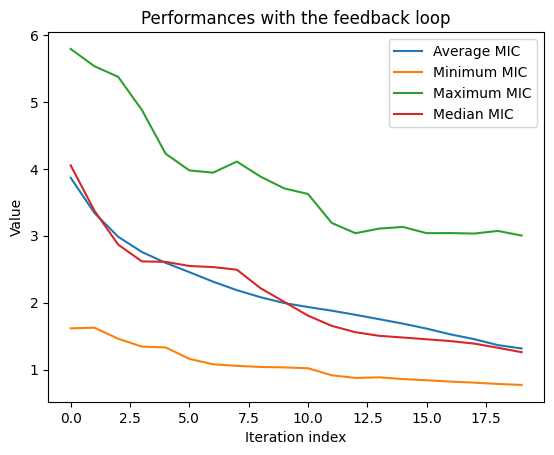

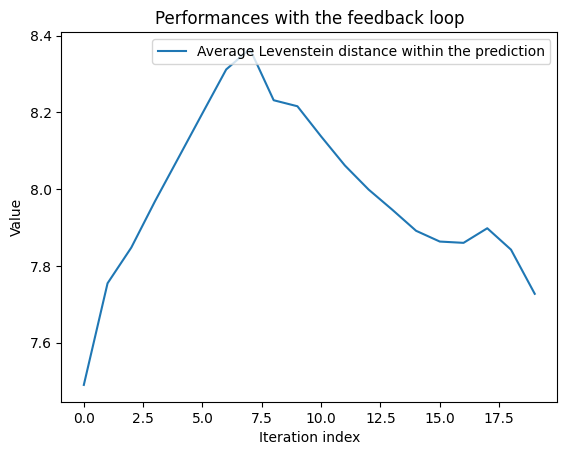

['EVIVkDDKkKFkKK',
 'EVIKkDDKkKFFKK',
 'GVKKLAKKQKKLFK',
 'GVKKLAKKLKKLFK',
 'AVIW',
 'MVKKLAKKQKKLFK',
 'MVKKLAKKLKKLFK',
 'AVIWFL',
 'MVTVFKKLKKLFK',
 'MVKKLAKKLKKLFK']

In [18]:
latent_dim = 2
n_iter_max = 20
n_bins = 101
target = 'Bacillus_subtilis'

average_mic_train, min_mic_train, max_mic_train, median_mic_train, levenstein = RL_loop(generator, oracle, aa_vocal, pep_decoder, n_bins, target)
display({"Average MIC" : average_mic_train, "Minimum MIC" : min_mic_train, "Maximum MIC" : max_mic_train, "Median MIC" : median_mic_train})
display({"Average Levenstein distance within the prediction" : levenstein})
generate_sequences(generator, latent_dim, 10)